In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

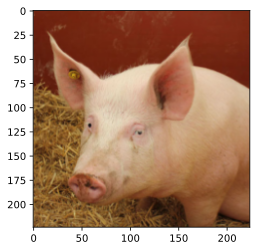

In [19]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [20]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [21]:
# form predictions
pred = model(norm(pig_tensor))

In [22]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [23]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

In [24]:
#Attack
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934622768312693
10 -0.015797581523656845
15 -0.08087803423404694
20 -11.66566276550293
25 -14.029595375061035
True class probability: 3.995435804426961e-08


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  (Note: we should also clip $x + \delta$ to be in $[0,1]$, but this already holds for any $\delta$ within the above bound, so we don't need to do it explicitly here).  Instead, it turns out that this classifier is quite sure the image is a wombat, as we can see from the following code, which computes the maximum class and its probability.

In [25]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9999409914016724


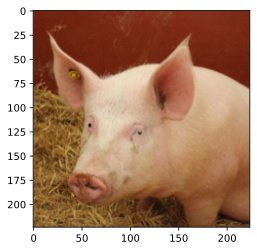

In [26]:
#wombatpig
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

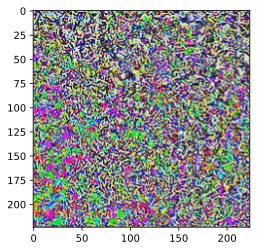

In [27]:
#wombatnoise
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [13]:
#Target Attack
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006046295166016
10 -0.1300830841064453
20 -7.94093132019043
30 -14.848793029785156
40 -20.922279357910156
50 -27.149904251098633
60 -30.706825256347656
70 -31.851829528808594
80 -36.17970275878906
90 -42.351593017578125


In [14]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.7559363842010498


As before, here's our airliner-pig, looking an awful lot like a normal pig (the target class of 404 from the code is indeed an airliner, so our targeted attack is working)

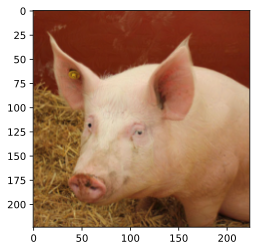

In [15]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

And here is our airliner noise.

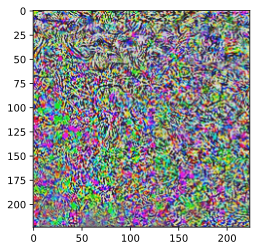

In [16]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))